In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision import transforms
from torch.nn.functional import relu
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import math

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") #using gpu
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

cuda:0


In [3]:
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

Minimum value: 0.0117647061124444
Maximum value: 1.0


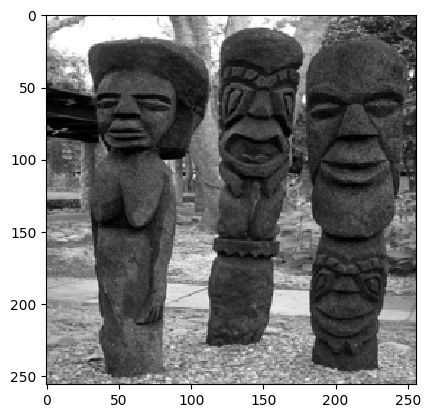

In [4]:
image = Image.open("blurImages/test001.png")
testOutput = preprocess(image).unsqueeze(0)

min_value = np.min(testOutput.squeeze(0).cpu().numpy())
max_value = np.max(testOutput.squeeze(0).cpu().numpy())
print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")
plt.imshow(testOutput.squeeze().numpy(),cmap='gray',interpolation='none')

In [5]:
class UNetDenoise(nn.Module):
    #layers definition
    def __init__(self): #constructor for uNetDenoise
        super().__init__() #constructor of parent class to init inherited attributes
        #Encoder portion, with 256x256x3 input. Padding: same for 3x3 convolutions

        #1st downsample layer
        self.conv11 = nn.Conv2d(2,64,kernel_size=3, padding=1) #dataset images are black and white
        self.conv12 = nn.Conv2d(64,64, kernel_size=3, padding=1) #keep padding same, (kernselSize-1)/2
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)

        #2nd downsample layer
        self.conv21 = nn.Conv2d(64,128,kernel_size=3, padding=1)
        self.conv22 = nn.Conv2d(128,128,kernel_size=3, padding=1)
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2)

        #3rd downsample layer
        self.conv31 = nn.Conv2d(128,256,kernel_size=3, padding=1)
        self.conv32 = nn.Conv2d(256,256,kernel_size=3, padding=1)
        self.pool3=nn.MaxPool2d(kernel_size=2, stride=2)

        #4th downsample layer
        self.conv41 = nn.Conv2d(256,512,kernel_size=3, padding=1)
        self.conv42 = nn.Conv2d(512,512,kernel_size=3, padding=1)
        self.pool4=nn.MaxPool2d(kernel_size=2, stride=2)

        #bottle neck
        self.conv51 = nn.Conv2d(512,1024,kernel_size=3, padding=1)
        self.conv52 = nn.Conv2d(1024,1024,kernel_size=3, padding=1)

        #upsample 1
        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #1024, but half 
        self.u11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.u12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        #upsample 2
        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.u21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.u22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        #upsample 3
        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.u31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.u32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        #upsample 4
        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.u41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.u42 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        #encoder forward
        xconv11 = relu(self.conv11(x))
        xconv12 = relu(self.conv12(xconv11))
        xpool1 = self.pool1(xconv12)

        xconv21 = relu(self.conv21(xpool1))
        xconv22 = relu(self.conv22(xconv21))
        xpool2 = self.pool2(xconv22)

        xconv31 = relu(self.conv31(xpool2))
        xconv32 = relu(self.conv32(xconv31))
        xpool3 = self.pool3(xconv32)

        xconv41 = relu(self.conv41(xpool3))
        xconv42 = relu(self.conv42(xconv41))
        xpool4 = self.pool4(xconv42)

        xconv51 = relu(self.conv51(xpool4))
        xconv52 = relu(self.conv52(xconv51))

        #decoder forward 
        xup1 = self.upconv1(xconv52)
        xu11 = torch.cat([xup1, xconv42], dim=1)
        xd11 = relu(self.u11(xu11))
        xd12 = relu(self.u12(xd11))

        xup2 = self.upconv2(xd12)
        xu22 = torch.cat([xup2, xconv32], dim=1)
        xd21 = relu(self.u21(xu22))
        xd22 = relu(self.u22(xd21))

        xup3 = self.upconv3(xd22)
        xu33 = torch.cat([xup3, xconv22], dim=1)
        xd31 = relu(self.u31(xu33))
        xd32 = relu(self.u32(xd31))

        xup4 = self.upconv4(xd32)
        xu44 = torch.cat([xup4, xconv12], dim=1)
        xd41 = relu(self.u41(xu44))
        xd42 = relu(self.u42(xd41))

        return xd42

In [6]:
kernel_size = 9
if kernel_size%2 == 0: #kernel size should be odd
    kernel_size = kernel_size-1

In [7]:
def create_gaussian_kernel(kernel_size=9, sigma=1.5):
    
    x = torch.arange(kernel_size) - (kernel_size - 1) / 2
    y = x.view(kernel_size, 1)
    x2y2 = x**2 + y**2
    
    gaussian_kernel = torch.exp(-x2y2 / (2 * sigma**2))
    gaussian_kernel = gaussian_kernel / (2 * np.pi * sigma**2)
    
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
    return gaussian_kernel

In [8]:
#noise level map
def genNoiseMap(image, sigmaNorm):
    noiselvlMap = torch.full_like(image, sigmaNorm)
    return noiselvlMap
def combineImgandMap(imageNoised, noiselvlMap): #input image needs to be noised
    combinedInput = torch.cat((imageNoised, noiselvlMap), dim=1)
    return combinedInput
def addNoiseMap(imageNoised, sigmaNorm): #image needs to be noised, sigma should be normalized?
    noiselvlMap = genNoiseMap(imageNoised, sigmaNorm)
    return combineImgandMap(imageNoised, noiselvlMap)

In [9]:
class BlurModel(nn.Module):
    def __init__(self):
        super(BlurModel, self).__init__()
        
        self.k= create_gaussian_kernel(kernel_size, 1.5)

        self.k = self.k.view(1,1,kernel_size,kernel_size)
        self.k = self.k.to(device)
    # def forward(self, x, sigma=0):
    #     # A y

    #     #need new padding size with larger kernel
    #     padding_size = kernel_size//2
        
    #     x_padded = F.pad(x, (padding_size,padding_size,padding_size,padding_size), mode='circular')
    #     #applying blur and noise
    #     y = F.conv2d(x_padded, self.k) + sigma * torch.randn_like(x)
    #     return y

    def forward(self, x):
        # A y

        #need new padding size with larger kernel
        padding_size = kernel_size//2
        
        x_padded = F.pad(x, (padding_size,padding_size,padding_size,padding_size), mode='circular')
        #applying blur without noise
        y = F.conv2d(x_padded, self.k)
        return y
    
    def tran(self, y):
        # A^T y
#         x = NotImplemented # hint: transpose the blur kernel
        self.k = torch.transpose(self.k, 0, 1)

        #need new padding size with larger kernel
        padding_size = kernel_size//2
        
        y_padded = F.pad(y, (padding_size, padding_size, padding_size, padding_size), mode='circular')
        #kTranposed = self.k.t()
        x = F.conv2d(y_padded, self.k, padding=0) #self.k is symmetric
        return x
    
    def grad(self, x, y):
        # gradient of 0.5 || Ax - y ||^2 --> grad = A^T(Ax - y)
        g = self.tran( self.forward(x) - y )
        return g

    def calcLoss(self, x, y):
        diff = self.forward(x) - y
        diffSquared = diff ** 2
        return 0.5*torch.sum(diffSquared)


In [10]:
def psnrCalc(mse, max):
    return 10*np.log10((max**2)/mse)


In [11]:
def run_PnP_ISTA(
             x0,
             A, 
             denoiser,
             meas, 
             stepsize,
             gt_img, 
             max_iter,
             sigmaNoiseMap,
             meas_sigma,
            ):
    # ############################
    # A basic implementation of PnP ISTA
    # ############################

    #initializing and adding noise
    x = x0 + meas_sigma * torch.randn_like(x0)
    with torch.no_grad():
        for i in tqdm(range(max_iter)):
            # Look at PnP ISTA update steps
            
            z = x - stepsize*A.grad(x, meas) #prev x - stepsize*grad(prev x)

            #adding noise map to z:
            z = addNoiseMap(z, sigmaNoiseMap)

            #plug into denoiser
            x = denoiser(z)
        
            #Feel free to add psnr/ssim tracking
            #track loss of (y-AX)^2
            #check if fista is running properly: set x=z, initailize image to zeros, simga=0 and you'll converge
            if i % 10 == 0:
                gt_img_np = gt_img.cpu().detach().numpy() if gt_img.is_cuda else gt_img.numpy()
                x_np = x.cpu().detach().numpy() if x.is_cuda else x.detach().numpy()
                meas_np = meas.cpu().detach().numpy() if meas.is_cuda else x.detach().numpy()
                #psnr of output
                mseTerm = mse(gt_img_np,x_np)
                curPsnr = psnrCalc(mseTerm, 1)
                curLoss = A.calcLoss(x, meas)
        
                #psnr of measurement
                mseTermMeas = mse(gt_img_np,meas_np)
                curPsnrMeas = psnrCalc(mseTermMeas, 1)

                psnrList.append(curPsnr)
                lossList.append(curLoss) #x is clean image, y is measurement
                print(f"At iter {i}, loss is: {curLoss}, PSNR of output is: {curPsnr}, PSNR of input is: {curPsnrMeas}");
    return x

In [12]:
findBestStepSize = False

In [13]:
max_iter = 200
stepsize = [2, 1, 0.9, 0.8, 0.5, 0.3, 0.1, 0.05, 0.01] # play with this
meas_sigma = 15 / 255 # play with this (note that it does not need to be same as the sigma you used for training)
bestPsnr = float('-inf')
bestStepSize = 0
#sigma for noise map
sigmaSampled = torch.randint(1,50,(1,1)).item() #each image have diff sigma
sigmaNoiseMap = sigmaSampled/255

A = BlurModel().to(device) # forward model

clean_img = preprocess(image).unsqueeze(0)
clean_img = clean_img.to(device)
blurry_img = A(clean_img)

network = UNetDenoise()
network.load_state_dict(torch.load('denoiserFinalWeightswNoiseMap.pth')) # Your NN you trained 
#denoiserFinalWeights.pth denoiserModelBestWeights.pth denoiserFinalWeightsEarlyStopped.pth denoiserModelBestWeightsEarlyStopped.pth denoiserFinalWeightswNoiseMap.pth 
network.eval()

#x0 = torch.zeros_like(blurry_img)
x0 = blurry_img
network.to(device)
blurry_img = blurry_img.to(device)

x0 = x0.to(device)
# if findBestStepSize:
#     for aStepsize in stepsize:
#         lossList = list()
#         psnrList = list()
#         print(f'step size of: {aStepsize}')
#         recon = run_PnP_ISTA(x0 = x0, # For deblurring, initializing with the blurry image can work
#                              A = A, 
#                              denoiser = network,
#                              meas = blurry_img, 
#                              stepsize = aStepsize,
#                              gt_img = clean_img, 
#                              max_iter = max_iter
#                         )
#         print(f'final psnr with stepsize {aStepsize}: {psnrList[-1]}')
    
#         if psnrList[-1] > bestPsnr:
#             bestPsnr = psnrList[-1]
#             bestStepSize = aStepsize
    
#         fig, ax = plt.subplots(1,4)
#         plt.title(f'At StepSize: {aStepsize} clean, pre reconstruction, measurment, and estimated images')
#         ax[0].imshow(clean_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
#         ax[1].imshow(x0[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
#         ax[2].imshow(blurry_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
#         ax[3].imshow(recon[0,0].cpu().detach().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')


  0%|          | 1/500 [00:00<01:13,  6.76it/s]

At iter 0, loss is: 7.334367752075195, PSNR of output is: 24.56145029353102, PSNR of input is: 24.799891158716747


  2%|▏         | 11/500 [00:00<00:15, 30.71it/s]

At iter 10, loss is: 5.770936965942383, PSNR of output is: 24.732419609979214, PSNR of input is: 24.799891158716747
At iter 20, loss is: 5.7837605476379395, PSNR of output is: 24.721349323156907, PSNR of input is: 24.799891158716747


  6%|▌         | 31/500 [00:00<00:10, 42.71it/s]

At iter 30, loss is: 5.782694339752197, PSNR of output is: 24.721340812305165, PSNR of input is: 24.799891158716747
At iter 40, loss is: 5.782535552978516, PSNR of output is: 24.72139589457307, PSNR of input is: 24.799891158716747


 10%|█         | 51/500 [00:01<00:09, 46.05it/s]

At iter 50, loss is: 5.782553195953369, PSNR of output is: 24.72138538533955, PSNR of input is: 24.799891158716747


 12%|█▏        | 61/500 [00:01<00:09, 46.88it/s]

At iter 60, loss is: 5.782556533813477, PSNR of output is: 24.721383145343395, PSNR of input is: 24.799891158716747


 14%|█▍        | 71/500 [00:01<00:09, 47.27it/s]

At iter 70, loss is: 5.782556533813477, PSNR of output is: 24.72138293487685, PSNR of input is: 24.799891158716747


 18%|█▊        | 91/500 [00:02<00:08, 48.00it/s]

At iter 80, loss is: 5.782556533813477, PSNR of output is: 24.72138304687647, PSNR of input is: 24.799891158716747
At iter 90, loss is: 5.782556533813477, PSNR of output is: 24.721383044387338, PSNR of input is: 24.799891158716747


 20%|██        | 101/500 [00:02<00:08, 48.03it/s]

At iter 100, loss is: 5.782557010650635, PSNR of output is: 24.72138295813966, PSNR of input is: 24.799891158716747


 24%|██▍       | 121/500 [00:02<00:07, 48.19it/s]

At iter 110, loss is: 5.782556533813477, PSNR of output is: 24.721382927359112, PSNR of input is: 24.799891158716747
At iter 120, loss is: 5.782556533813477, PSNR of output is: 24.7213829548804, PSNR of input is: 24.799891158716747


 26%|██▌       | 131/500 [00:02<00:07, 48.02it/s]

At iter 130, loss is: 5.782557010650635, PSNR of output is: 24.721382897657946, PSNR of input is: 24.799891158716747


 28%|██▊       | 141/500 [00:03<00:07, 47.91it/s]

At iter 140, loss is: 5.782556533813477, PSNR of output is: 24.721382944002027, PSNR of input is: 24.799891158716747


 30%|███       | 151/500 [00:03<00:07, 47.42it/s]

At iter 150, loss is: 5.782557010650635, PSNR of output is: 24.721382922921407, PSNR of input is: 24.799891158716747


 32%|███▏      | 161/500 [00:03<00:07, 47.55it/s]

At iter 160, loss is: 5.782557010650635, PSNR of output is: 24.721382892285206, PSNR of input is: 24.799891158716747


 34%|███▍      | 171/500 [00:03<00:06, 47.25it/s]

At iter 170, loss is: 5.782556533813477, PSNR of output is: 24.72138289724009, PSNR of input is: 24.799891158716747


 38%|███▊      | 191/500 [00:04<00:06, 47.86it/s]

At iter 180, loss is: 5.782556533813477, PSNR of output is: 24.721382878537128, PSNR of input is: 24.799891158716747
At iter 190, loss is: 5.782557010650635, PSNR of output is: 24.721382979664778, PSNR of input is: 24.799891158716747


 42%|████▏     | 211/500 [00:04<00:06, 47.94it/s]

At iter 200, loss is: 5.782556533813477, PSNR of output is: 24.721382903515924, PSNR of input is: 24.799891158716747
At iter 210, loss is: 5.782556533813477, PSNR of output is: 24.721382902687235, PSNR of input is: 24.799891158716747


 46%|████▌     | 231/500 [00:04<00:05, 47.89it/s]

At iter 220, loss is: 5.782556533813477, PSNR of output is: 24.721382905064292, PSNR of input is: 24.799891158716747
At iter 230, loss is: 5.782556533813477, PSNR of output is: 24.72138291753543, PSNR of input is: 24.799891158716747


 50%|█████     | 251/500 [00:05<00:05, 48.28it/s]

At iter 240, loss is: 5.782557010650635, PSNR of output is: 24.72138284821994, PSNR of input is: 24.799891158716747
At iter 250, loss is: 5.782557010650635, PSNR of output is: 24.721382896242293, PSNR of input is: 24.799891158716747


 52%|█████▏    | 261/500 [00:05<00:04, 48.30it/s]

At iter 260, loss is: 5.782557487487793, PSNR of output is: 24.721382889598406, PSNR of input is: 24.799891158716747
At iter 270, loss is: 5.782557010650635, PSNR of output is: 24.721382874252747, PSNR of input is: 24.799891158716747


 56%|█████▌    | 281/500 [00:06<00:04, 48.47it/s]

At iter 280, loss is: 5.782556533813477, PSNR of output is: 24.721382896678683, PSNR of input is: 24.799891158716747


 60%|██████    | 301/500 [00:06<00:04, 48.41it/s]

At iter 290, loss is: 5.782556533813477, PSNR of output is: 24.721382918426038, PSNR of input is: 24.799891158716747
At iter 300, loss is: 5.782557010650635, PSNR of output is: 24.721382944179524, PSNR of input is: 24.799891158716747


 64%|██████▍   | 321/500 [00:06<00:03, 48.44it/s]

At iter 310, loss is: 5.782556533813477, PSNR of output is: 24.721383009926527, PSNR of input is: 24.799891158716747
At iter 320, loss is: 5.782557010650635, PSNR of output is: 24.721382920454072, PSNR of input is: 24.799891158716747


 68%|██████▊   | 341/500 [00:07<00:03, 48.60it/s]

At iter 330, loss is: 5.782556533813477, PSNR of output is: 24.721382879617344, PSNR of input is: 24.799891158716747
At iter 340, loss is: 5.782556533813477, PSNR of output is: 24.721382922107736, PSNR of input is: 24.799891158716747


 70%|███████   | 351/500 [00:07<00:03, 48.59it/s]

At iter 350, loss is: 5.782556533813477, PSNR of output is: 24.721382915854107, PSNR of input is: 24.799891158716747


 74%|███████▍  | 371/500 [00:07<00:02, 48.46it/s]

At iter 360, loss is: 5.782556533813477, PSNR of output is: 24.721382915708745, PSNR of input is: 24.799891158716747
At iter 370, loss is: 5.782556533813477, PSNR of output is: 24.721382914286387, PSNR of input is: 24.799891158716747


 78%|███████▊  | 391/500 [00:08<00:02, 48.64it/s]

At iter 380, loss is: 5.782557010650635, PSNR of output is: 24.72138291670852, PSNR of input is: 24.799891158716747
At iter 390, loss is: 5.782556533813477, PSNR of output is: 24.72138295422491, PSNR of input is: 24.799891158716747


 82%|████████▏ | 411/500 [00:08<00:01, 48.01it/s]

At iter 400, loss is: 5.782557010650635, PSNR of output is: 24.72138292350134, PSNR of input is: 24.799891158716747
At iter 410, loss is: 5.782556533813477, PSNR of output is: 24.721382946617872, PSNR of input is: 24.799891158716747


 84%|████████▍ | 421/500 [00:08<00:01, 48.32it/s]

At iter 420, loss is: 5.782557010650635, PSNR of output is: 24.721382890469066, PSNR of input is: 24.799891158716747
At iter 430, loss is: 5.782556533813477, PSNR of output is: 24.721382949382473, PSNR of input is: 24.799891158716747


 88%|████████▊ | 441/500 [00:09<00:01, 48.01it/s]

At iter 440, loss is: 5.782557010650635, PSNR of output is: 24.721382961327162, PSNR of input is: 24.799891158716747


 90%|█████████ | 451/500 [00:09<00:01, 47.97it/s]

At iter 450, loss is: 5.782556533813477, PSNR of output is: 24.72138296651481, PSNR of input is: 24.799891158716747


 92%|█████████▏| 461/500 [00:09<00:00, 48.22it/s]

At iter 460, loss is: 5.782557010650635, PSNR of output is: 24.72138294889708, PSNR of input is: 24.799891158716747


 94%|█████████▍| 471/500 [00:09<00:00, 48.39it/s]

At iter 470, loss is: 5.782557487487793, PSNR of output is: 24.721382915447222, PSNR of input is: 24.799891158716747


 96%|█████████▌| 481/500 [00:10<00:00, 48.59it/s]

At iter 480, loss is: 5.782557487487793, PSNR of output is: 24.721382894153958, PSNR of input is: 24.799891158716747
At iter 490, loss is: 5.782557010650635, PSNR of output is: 24.721382873909548, PSNR of input is: 24.799891158716747


100%|██████████| 500/500 [00:10<00:00, 48.26it/s]


(-0.5, 255.5, 255.5, -0.5)

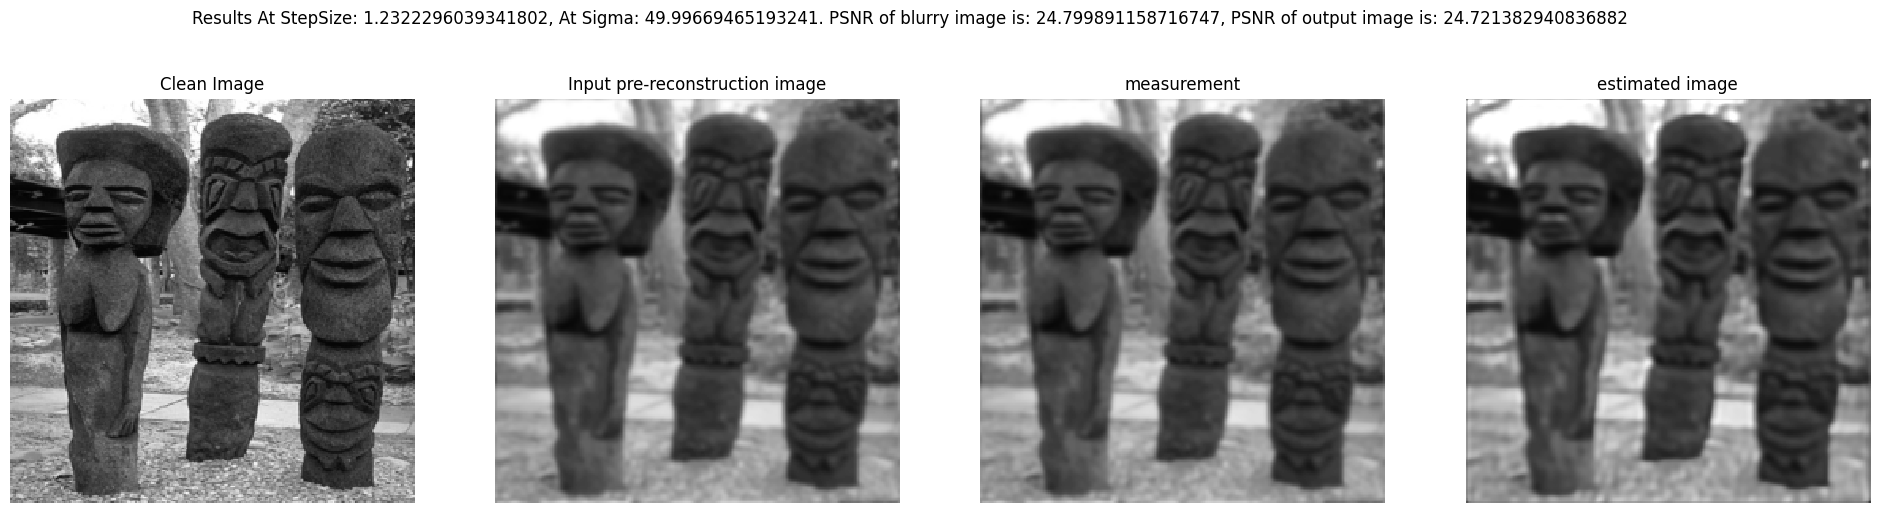

In [30]:
#best step size is found to be 1
lossList = list()
psnrList = list()
recon = run_PnP_ISTA(x0 = x0, # For deblurring, initializing with the blurry image can work
                         A = A, 
                         denoiser = network,
                         meas = blurry_img, 
                         stepsize = 1,
                         gt_img = clean_img, 
                         max_iter = 500,
                         sigmaNoiseMap = sigmaNoiseMap,
                         meas_sigma = meas_sigma
                    )

blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.numpy()
recon_np = recon.cpu().detach().numpy() if recon.is_cuda else recon.numpy()
mseTermRecon = mse(clean_img_np, recon_np)
mseTermBlurred = mse(clean_img_np,blurry_img_np)

finalPsnrOutput = psnrCalc(mseTermRecon,1)
finalPsnrMeas = psnrCalc(mseTermBlurred,1)

fig, ax = plt.subplots(1,4, figsize=(24,6))

fig.suptitle(f'Results At StepSize: {bestStepsize}, At Sigma: {sigma}. PSNR of blurry image is: {finalPsnrMeas}, PSNR of output image is: {finalPsnrOutput}')

ax[0].imshow(clean_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[0].set_title("Clean Image", fontsize=12)
ax[0].axis('off')
ax[1].imshow(x0[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[1].set_title("Input pre-reconstruction image", fontsize=12)
ax[1].axis('off')
ax[2].imshow(blurry_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[2].set_title("measurement", fontsize=12)
ax[2].axis('off')
ax[3].imshow(recon[0,0].cpu().detach().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[3].set_title("estimated image", fontsize=12)
ax[3].axis('off')

In [15]:
blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.numpy()
recon = recon.cpu().detach().numpy() if recon.is_cuda else recon.numpy()
mseTermRecon = mse(clean_img_np, recon)
mseTermBlurred = mse(clean_img_np,blurry_img_np)

finalPsnrOutput = psnrCalc(mseTermRecon,1)
finalPsnrMeas = psnrCalc(mseTermBlurred,1)

print(f'Final result PSNR of blurred image {finalPsnrMeas}')
print(f'Final result PSNR of reconstructed image {finalPsnrOutput}')

Final result PSNR of blurred image 24.799891158716747
Final result PSNR of reconstructed image 24.721382921391196


In [16]:
import scipy

In [17]:
def objFuncStepSize(stepsize):
    imgRecon = run_PnP_ISTA(x0=x0, A=A, denoiser=network, meas=blurry_img, stepsize=1e-6, gt_img=clean_img, max_iter=200, sigmaNoiseMap = sigmaNoiseMap, meas_sigma=15/255) #pass in sigma,
    blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
    clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.detach().numpy()
    imgRecon_np = imgRecon.cpu().detach().numpy() if isinstance(imgRecon, torch.Tensor) else imgRecon
    mseTermRecon = mse(clean_img_np, imgRecon_np)
    mseTermBlurred = mse(clean_img_np, blurry_img_np)
    return -psnrCalc(mseTermRecon, 1)

In [18]:
bestStepsize = scipy.optimize.fminbound(objFuncStepSize,1e-6,2,xtol=1e-3,maxfun=20,disp=3)

  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.40566635131836, PSNR of output is: 23.898600473544892, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.24it/s]

At iter 10, loss is: 85.72451782226562, PSNR of output is: 21.296677615727262, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 46.29it/s]

At iter 20, loss is: 222.34695434570312, PSNR of output is: 19.10829217666228, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.79it/s]

At iter 30, loss is: 429.70526123046875, PSNR of output is: 17.16887744595435, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 47.23it/s]

At iter 40, loss is: 708.6851196289062, PSNR of output is: 15.48904343745212, PSNR of input is: 24.799891158716747
At iter 50, loss is: 1059.72607421875, PSNR of output is: 14.033148591683373, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.44it/s]

At iter 60, loss is: 1484.7369384765625, PSNR of output is: 12.754908214793586, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 47.66it/s]

At iter 70, loss is: 1988.892578125, PSNR of output is: 11.611398582285142, PSNR of input is: 24.799891158716747
At iter 80, loss is: 2581.3017578125, PSNR of output is: 10.568966045376946, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.74it/s]

At iter 90, loss is: 3269.69189453125, PSNR of output is: 9.608655620720963, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 47.85it/s]

At iter 100, loss is: 4062.01025390625, PSNR of output is: 8.716363691375422, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 47.72it/s]

At iter 110, loss is: 4967.1328125, PSNR of output is: 7.880483406708767, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 47.70it/s]

At iter 120, loss is: 5999.5712890625, PSNR of output is: 7.088312003512984, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 47.65it/s]

At iter 130, loss is: 7173.9970703125, PSNR of output is: 6.331644282919332, PSNR of input is: 24.799891158716747
At iter 140, loss is: 8507.173828125, PSNR of output is: 5.604106709860988, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.79it/s]

At iter 150, loss is: 10022.8994140625, PSNR of output is: 4.898451273386488, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.69it/s]

At iter 160, loss is: 11771.7470703125, PSNR of output is: 4.199499401351253, PSNR of input is: 24.799891158716747
At iter 170, loss is: 13848.931640625, PSNR of output is: 3.4837586839733445, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 47.82it/s]

At iter 180, loss is: 16392.09375, PSNR of output is: 2.7285592966352623, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.48it/s]


At iter 190, loss is: 19591.05859375, PSNR of output is: 1.9196273304027436, PSNR of input is: 24.799891158716747
 
 Func-count     x          f(x)          Procedure
    1       0.763933     -1.13633        initial


  6%|▌         | 11/200 [00:00<00:03, 47.85it/s]

At iter 0, loss is: 15.512212753295898, PSNR of output is: 23.876336977800015, PSNR of input is: 24.799891158716747
At iter 10, loss is: 85.81085205078125, PSNR of output is: 21.294902388337967, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 47.87it/s]

At iter 20, loss is: 222.92320251464844, PSNR of output is: 19.104085525595227, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.26it/s]

At iter 30, loss is: 431.04388427734375, PSNR of output is: 17.162534737477955, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.64it/s]

At iter 40, loss is: 709.914794921875, PSNR of output is: 15.487097619893262, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.68it/s]

At iter 50, loss is: 1061.117431640625, PSNR of output is: 14.03266148978597, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.78it/s]

At iter 60, loss is: 1486.79150390625, PSNR of output is: 12.753676852527915, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 47.06it/s]

At iter 70, loss is: 1990.99072265625, PSNR of output is: 11.611041818391339, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.15it/s]

At iter 80, loss is: 2582.4130859375, PSNR of output is: 10.571119718100828, PSNR of input is: 24.799891158716747
At iter 90, loss is: 3268.821533203125, PSNR of output is: 9.613673715308362, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 47.38it/s]

At iter 100, loss is: 4058.154296875, PSNR of output is: 8.723651702082503, PSNR of input is: 24.799891158716747
At iter 110, loss is: 4961.16064453125, PSNR of output is: 7.887993009349897, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 47.39it/s]

At iter 120, loss is: 5990.00048828125, PSNR of output is: 7.097272229226569, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 47.40it/s]

At iter 130, loss is: 7158.48583984375, PSNR of output is: 6.343577264687746, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 46.74it/s]

At iter 140, loss is: 8482.623046875, PSNR of output is: 5.619993780102651, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.94it/s]

At iter 150, loss is: 9985.376953125, PSNR of output is: 4.9189495476703184, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.95it/s]

At iter 160, loss is: 11709.880859375, PSNR of output is: 4.227419656141404, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.02it/s]

At iter 170, loss is: 13738.310546875, PSNR of output is: 3.525215315726931, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 47.21it/s]

At iter 180, loss is: 16189.912109375, PSNR of output is: 2.7931804748085494, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.02it/s]


At iter 190, loss is: 19219.8359375, PSNR of output is: 2.0194554305538865, PSNR of input is: 24.799891158716747
    2        1.23607     -1.28075        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.56920051574707, PSNR of output is: 23.881615344312344, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.29it/s]

At iter 10, loss is: 84.74566650390625, PSNR of output is: 21.31144732836146, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.52it/s]

At iter 20, loss is: 219.14776611328125, PSNR of output is: 19.149639001793467, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.58it/s]

At iter 30, loss is: 423.4236145019531, PSNR of output is: 17.22162191838485, PSNR of input is: 24.799891158716747
At iter 40, loss is: 699.6300048828125, PSNR of output is: 15.541393465848799, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.13it/s]

At iter 50, loss is: 1047.916259765625, PSNR of output is: 14.082564941265712, PSNR of input is: 24.799891158716747
At iter 60, loss is: 1469.1279296875, PSNR of output is: 12.803341123880463, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 47.23it/s]

At iter 70, loss is: 1967.253173828125, PSNR of output is: 11.6622090532561, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 47.36it/s]

At iter 80, loss is: 2549.96875, PSNR of output is: 10.62576717515978, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 47.34it/s]

At iter 90, loss is: 3225.5732421875, PSNR of output is: 9.671830414057412, PSNR of input is: 24.799891158716747
At iter 100, loss is: 4001.160888671875, PSNR of output is: 8.78565739337667, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 47.52it/s]

At iter 110, loss is: 4886.08056640625, PSNR of output is: 7.954780581100125, PSNR of input is: 24.799891158716747
At iter 120, loss is: 5893.2978515625, PSNR of output is: 7.167981352105311, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 47.56it/s]

At iter 130, loss is: 7037.5263671875, PSNR of output is: 6.416950142203008, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.72it/s]

At iter 140, loss is: 8335.326171875, PSNR of output is: 5.694671818071086, PSNR of input is: 24.799891158716747
At iter 150, loss is: 9811.642578125, PSNR of output is: 4.9926931543603565, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.76it/s]

At iter 160, loss is: 11512.43359375, PSNR of output is: 4.297167574263291, PSNR of input is: 24.799891158716747
At iter 170, loss is: 13525.21875, PSNR of output is: 3.586297930458002, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 47.72it/s]

At iter 180, loss is: 15983.515625, PSNR of output is: 2.8377015192118056, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.25it/s]


At iter 190, loss is: 19083.19140625, PSNR of output is: 2.0332722867011417, PSNR of input is: 24.799891158716747
    3        1.52786     -1.24691        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.250577926635742, PSNR of output is: 23.91450685342405, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:03, 47.64it/s]

At iter 10, loss is: 85.79906463623047, PSNR of output is: 21.293975474836607, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 46.89it/s]

At iter 20, loss is: 223.02105712890625, PSNR of output is: 19.100247931968813, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.06it/s]

At iter 30, loss is: 430.8355407714844, PSNR of output is: 17.16088889836419, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.41it/s]

At iter 40, loss is: 710.1358032226562, PSNR of output is: 15.482772289822496, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.77it/s]

At iter 50, loss is: 1061.69970703125, PSNR of output is: 14.027054871833899, PSNR of input is: 24.799891158716747
At iter 60, loss is: 1487.9183349609375, PSNR of output is: 12.74712184235022, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.56it/s]

At iter 70, loss is: 1995.5030517578125, PSNR of output is: 11.598445950295952, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.48it/s]

At iter 80, loss is: 2593.087158203125, PSNR of output is: 10.550508366678315, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.30it/s]

At iter 90, loss is: 3289.024169921875, PSNR of output is: 9.584180546214071, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 45.98it/s]

At iter 100, loss is: 4090.3251953125, PSNR of output is: 8.686302547829548, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.02it/s]

At iter 110, loss is: 5009.24462890625, PSNR of output is: 7.842726925060228, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.04it/s]

At iter 120, loss is: 6062.775390625, PSNR of output is: 7.04089795391852, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.39it/s]

At iter 130, loss is: 7268.55810546875, PSNR of output is: 6.2727230879705145, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.87it/s]

At iter 140, loss is: 8646.1064453125, PSNR of output is: 5.5318665681474375, PSNR of input is: 24.799891158716747
At iter 150, loss is: 10222.3984375, PSNR of output is: 4.810837557939907, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.57it/s]

At iter 160, loss is: 12046.7177734375, PSNR of output is: 4.096473145455216, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.56it/s]

At iter 170, loss is: 14208.3974609375, PSNR of output is: 3.3684521346699734, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.23it/s]

At iter 180, loss is: 16846.494140625, PSNR of output is: 2.606137441137828, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.29it/s]


At iter 190, loss is: 20152.58984375, PSNR of output is: 1.7954267146534493, PSNR of input is: 24.799891158716747
    4        1.27697     -1.00847        parabolic


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.482540130615234, PSNR of output is: 23.87855703510092, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 47.20it/s]

At iter 10, loss is: 85.89218139648438, PSNR of output is: 21.289278675190975, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.71it/s]

At iter 20, loss is: 223.89126586914062, PSNR of output is: 19.087903945522175, PSNR of input is: 24.799891158716747
At iter 30, loss is: 434.376220703125, PSNR of output is: 17.132934731915586, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 47.03it/s]

At iter 40, loss is: 720.207275390625, PSNR of output is: 15.430926552536326, PSNR of input is: 24.799891158716747
At iter 50, loss is: 1081.592529296875, PSNR of output is: 13.954814743109702, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 47.25it/s]

At iter 60, loss is: 1519.068603515625, PSNR of output is: 12.663149097390967, PSNR of input is: 24.799891158716747
At iter 70, loss is: 2037.8177490234375, PSNR of output is: 11.51127966376852, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 47.32it/s]

At iter 80, loss is: 2647.3564453125, PSNR of output is: 10.463300302558762, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.35it/s]

At iter 90, loss is: 3355.74853515625, PSNR of output is: 9.49881793322942, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 47.37it/s]

At iter 100, loss is: 4171.50439453125, PSNR of output is: 8.60283500244631, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 47.42it/s]

At iter 110, loss is: 5104.04345703125, PSNR of output is: 7.763546695617389, PSNR of input is: 24.799891158716747
At iter 120, loss is: 6165.6787109375, PSNR of output is: 6.970433262402652, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 47.35it/s]

At iter 130, loss is: 7370.48779296875, PSNR of output is: 6.214743234117975, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.34it/s]

At iter 140, loss is: 8739.01953125, PSNR of output is: 5.487409029859723, PSNR of input is: 24.799891158716747
At iter 150, loss is: 10300.7421875, PSNR of output is: 4.7789023052726245, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 47.30it/s]

At iter 160, loss is: 12110.544921875, PSNR of output is: 4.073346745303538, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.33it/s]

At iter 170, loss is: 14265.9296875, PSNR of output is: 3.3486848299069343, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 47.22it/s]

At iter 180, loss is: 16902.84375, PSNR of output is: 2.58744156249157, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.13it/s]


At iter 190, loss is: 20205.671875, PSNR of output is: 1.7779930315250014, PSNR of input is: 24.799891158716747
    5        1.05573    -0.989778        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.125720024108887, PSNR of output is: 23.92019056365774, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 47.30it/s]

At iter 10, loss is: 85.37933349609375, PSNR of output is: 21.306748265425792, PSNR of input is: 24.799891158716747
At iter 20, loss is: 222.7119140625, PSNR of output is: 19.107864260599158, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.26it/s]

At iter 30, loss is: 432.329345703125, PSNR of output is: 17.15159198942824, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 47.08it/s]

At iter 40, loss is: 715.8611450195312, PSNR of output is: 15.453588956590478, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 47.20it/s]

At iter 50, loss is: 1073.2744140625, PSNR of output is: 13.984241031378934, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 47.13it/s]

At iter 60, loss is: 1505.9267578125, PSNR of output is: 12.697734264093267, PSNR of input is: 24.799891158716747
At iter 70, loss is: 2019.875, PSNR of output is: 11.547300175104269, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.16it/s]

At iter 80, loss is: 2624.413818359375, PSNR of output is: 10.49880253012166, PSNR of input is: 24.799891158716747
At iter 90, loss is: 3330.45556640625, PSNR of output is: 9.529451544744546, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 47.33it/s]

At iter 100, loss is: 4149.9716796875, PSNR of output is: 8.623037214660911, PSNR of input is: 24.799891158716747
At iter 110, loss is: 5095.560546875, PSNR of output is: 7.768525120781843, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 47.35it/s]

At iter 120, loss is: 6182.572265625, PSNR of output is: 6.956242791330092, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 47.24it/s]

At iter 130, loss is: 7427.697265625, PSNR of output is: 6.178899107768282, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 47.09it/s]

At iter 140, loss is: 8850.603515625, PSNR of output is: 5.430157628347861, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 47.13it/s]

At iter 150, loss is: 10479.3662109375, PSNR of output is: 4.702161523692859, PSNR of input is: 24.799891158716747
At iter 160, loss is: 12366.40234375, PSNR of output is: 3.9810504555564896, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 47.34it/s]

At iter 170, loss is: 14605.83203125, PSNR of output is: 3.246975257754807, PSNR of input is: 24.799891158716747
At iter 180, loss is: 17331.76171875, PSNR of output is: 2.481023580565195, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.15it/s]


At iter 190, loss is: 20740.31640625, PSNR of output is: 1.6668218518417617, PSNR of input is: 24.799891158716747
    6        1.16718    -0.874208        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.232471466064453, PSNR of output is: 23.909973340188113, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 47.03it/s]

At iter 10, loss is: 85.28898620605469, PSNR of output is: 21.304127006832594, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 47.00it/s]

At iter 20, loss is: 223.29412841796875, PSNR of output is: 19.096451398919076, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 47.01it/s]

At iter 30, loss is: 433.0711364746094, PSNR of output is: 17.142844086854463, PSNR of input is: 24.799891158716747
At iter 40, loss is: 715.9263916015625, PSNR of output is: 15.451424400564925, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 47.08it/s]

At iter 50, loss is: 1072.847412109375, PSNR of output is: 13.98473236588644, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.12it/s]

At iter 60, loss is: 1505.371826171875, PSNR of output is: 12.698373498093602, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 47.07it/s]

At iter 70, loss is: 2020.04736328125, PSNR of output is: 11.546292298747234, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.19it/s]

At iter 80, loss is: 2626.1259765625, PSNR of output is: 10.496095066705402, PSNR of input is: 24.799891158716747
At iter 90, loss is: 3332.247314453125, PSNR of output is: 9.528113031460038, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 47.14it/s]

At iter 100, loss is: 4147.3974609375, PSNR of output is: 8.627361311011201, PSNR of input is: 24.799891158716747
At iter 110, loss is: 5080.96728515625, PSNR of output is: 7.7828060216968, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 47.19it/s]

At iter 120, loss is: 6145.7099609375, PSNR of output is: 6.984139924230426, PSNR of input is: 24.799891158716747
At iter 130, loss is: 7355.59912109375, PSNR of output is: 6.223169548524591, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 47.19it/s]

At iter 140, loss is: 8729.466796875, PSNR of output is: 5.49179997315483, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.33it/s]

At iter 150, loss is: 10296.7490234375, PSNR of output is: 4.780193190918248, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 47.22it/s]

At iter 160, loss is: 12110.31640625, PSNR of output is: 4.073149436988074, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.15it/s]

At iter 170, loss is: 14266.845703125, PSNR of output is: 3.34843090247193, PSNR of input is: 24.799891158716747
At iter 180, loss is: 16910.275390625, PSNR of output is: 2.5843675414720995, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.01it/s]


At iter 190, loss is: 20265.25, PSNR of output is: 1.7610902382263818, PSNR of input is: 24.799891158716747
    7        1.20976    -0.952015        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.085309028625488, PSNR of output is: 23.915545804155283, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 47.24it/s]

At iter 10, loss is: 83.69750213623047, PSNR of output is: 21.33987779627403, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 47.21it/s]

At iter 20, loss is: 217.87423706054688, PSNR of output is: 19.167323611986518, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.21it/s]

At iter 30, loss is: 422.7536315917969, PSNR of output is: 17.22626370998204, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 47.03it/s]

At iter 40, loss is: 700.3616943359375, PSNR of output is: 15.534976378641229, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.07it/s]

At iter 50, loss is: 1050.71533203125, PSNR of output is: 14.068528257226783, PSNR of input is: 24.799891158716747
At iter 60, loss is: 1476.984619140625, PSNR of output is: 12.778129940201277, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 47.11it/s]

At iter 70, loss is: 1983.655029296875, PSNR of output is: 11.624526459319679, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 47.07it/s]

At iter 80, loss is: 2577.5146484375, PSNR of output is: 10.577435677494407, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.04it/s]

At iter 90, loss is: 3265.687255859375, PSNR of output is: 9.61593451978563, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 47.09it/s]

At iter 100, loss is: 4056.301513671875, PSNR of output is: 8.72354105286119, PSNR of input is: 24.799891158716747
At iter 110, loss is: 4961.318359375, PSNR of output is: 7.885553218934792, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 47.10it/s]

At iter 120, loss is: 5996.5654296875, PSNR of output is: 7.089680750019289, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 47.13it/s]

At iter 130, loss is: 7178.48583984375, PSNR of output is: 6.327649674239408, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 47.08it/s]

At iter 140, loss is: 8526.140625, PSNR of output is: 5.592478779509963, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.05it/s]

At iter 150, loss is: 10069.1689453125, PSNR of output is: 4.875339030721004, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.96it/s]

At iter 160, loss is: 11860.74609375, PSNR of output is: 4.161455943460063, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.96it/s]

At iter 170, loss is: 13997.07421875, PSNR of output is: 3.4288139375419475, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 47.00it/s]

At iter 180, loss is: 16632.41015625, PSNR of output is: 2.6532874947673974, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.97it/s]


At iter 190, loss is: 19985.1015625, PSNR of output is: 1.8188254446105054, PSNR of input is: 24.799891158716747
    8        1.25169     -1.00093        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.045306205749512, PSNR of output is: 23.92714448175445, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.44it/s]

At iter 10, loss is: 83.7005386352539, PSNR of output is: 21.339789066250763, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 46.86it/s]

At iter 20, loss is: 218.83177185058594, PSNR of output is: 19.152767969768384, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.14it/s]

At iter 30, loss is: 425.7076110839844, PSNR of output is: 17.20074080184155, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.43it/s]

At iter 40, loss is: 705.7921142578125, PSNR of output is: 15.505420422052312, PSNR of input is: 24.799891158716747
At iter 50, loss is: 1058.50634765625, PSNR of output is: 14.03914534117731, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.80it/s]

At iter 60, loss is: 1483.26318359375, PSNR of output is: 12.760436003166184, PSNR of input is: 24.799891158716747
At iter 70, loss is: 1985.3419189453125, PSNR of output is: 11.62066418800984, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.05it/s]

At iter 80, loss is: 2572.22607421875, PSNR of output is: 10.586248404780768, PSNR of input is: 24.799891158716747
At iter 90, loss is: 3251.25048828125, PSNR of output is: 9.635529475168848, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 47.09it/s]

At iter 100, loss is: 4029.4990234375, PSNR of output is: 8.753093874837441, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.99it/s]

At iter 110, loss is: 4917.3564453125, PSNR of output is: 7.924939221832497, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.98it/s]

At iter 120, loss is: 5929.05126953125, PSNR of output is: 7.139306942686478, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 47.12it/s]

At iter 130, loss is: 7080.396484375, PSNR of output is: 6.3879989204169085, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.11it/s]

At iter 140, loss is: 8388.9013671875, PSNR of output is: 5.664267094964974, PSNR of input is: 24.799891158716747
At iter 150, loss is: 9880.4736328125, PSNR of output is: 4.960076133640621, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 47.14it/s]

At iter 160, loss is: 11600.0517578125, PSNR of output is: 4.262693459785222, PSNR of input is: 24.799891158716747
At iter 170, loss is: 13634.3349609375, PSNR of output is: 3.550959748132634, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.84it/s]

At iter 180, loss is: 16116.529296875, PSNR of output is: 2.8026870781160937, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.60it/s]


At iter 190, loss is: 19246.7734375, PSNR of output is: 1.9983663554868363, PSNR of input is: 24.799891158716747
    9        1.22602     -1.21414        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.35132122039795, PSNR of output is: 23.909439688829785, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.48it/s]

At iter 10, loss is: 84.347900390625, PSNR of output is: 21.324738526672352, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 44.60it/s]

At iter 20, loss is: 220.23377990722656, PSNR of output is: 19.132309128051126, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 45.73it/s]

At iter 30, loss is: 428.8343811035156, PSNR of output is: 17.173117078786653, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.12it/s]

At iter 40, loss is: 710.9468994140625, PSNR of output is: 15.475322284424697, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.65it/s]

At iter 50, loss is: 1066.9117431640625, PSNR of output is: 14.005111922354562, PSNR of input is: 24.799891158716747
At iter 60, loss is: 1499.8270263671875, PSNR of output is: 12.712366227073474, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.76it/s]

At iter 70, loss is: 2015.57763671875, PSNR of output is: 11.554949432333288, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.69it/s]

At iter 80, loss is: 2620.26220703125, PSNR of output is: 10.505012546619614, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.71it/s]

At iter 90, loss is: 3322.88330078125, PSNR of output is: 9.539463123641783, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.79it/s]

At iter 100, loss is: 4132.88671875, PSNR of output is: 8.641527218035321, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.85it/s]

At iter 110, loss is: 5061.720703125, PSNR of output is: 7.798092295121296, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.75it/s]

At iter 120, loss is: 6123.9453125, PSNR of output is: 6.99824027436452, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.56it/s]

At iter 130, loss is: 7335.74609375, PSNR of output is: 6.233642653362631, PSNR of input is: 24.799891158716747
At iter 140, loss is: 8715.060546875, PSNR of output is: 5.497900537926082, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.62it/s]

At iter 150, loss is: 10289.40625, PSNR of output is: 4.782760656407467, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.66it/s]

At iter 160, loss is: 12112.0185546875, PSNR of output is: 4.0727553100468485, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.98it/s]

At iter 170, loss is: 14282.5, PSNR of output is: 3.3442331298592745, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.08it/s]

At iter 180, loss is: 16950.88671875, PSNR of output is: 2.574464566087576, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.21it/s]


At iter 190, loss is: 20340.71484375, PSNR of output is: 1.7460238939638597, PSNR of input is: 24.799891158716747
   10        1.24204    -0.935334        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.090330123901367, PSNR of output is: 23.905107076050975, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 44.93it/s]

At iter 10, loss is: 83.86117553710938, PSNR of output is: 21.33499012639819, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.47it/s]

At iter 20, loss is: 218.970703125, PSNR of output is: 19.153037148580353, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 45.47it/s]

At iter 30, loss is: 424.2047119140625, PSNR of output is: 17.213741880946287, PSNR of input is: 24.799891158716747
At iter 40, loss is: 700.419677734375, PSNR of output is: 15.534271497475928, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 45.77it/s]

At iter 50, loss is: 1048.663818359375, PSNR of output is: 14.07678206949807, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.16it/s]

At iter 60, loss is: 1469.7857666015625, PSNR of output is: 12.799251031028549, PSNR of input is: 24.799891158716747
At iter 70, loss is: 1966.589599609375, PSNR of output is: 11.661875677505813, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.35it/s]

At iter 80, loss is: 2545.845458984375, PSNR of output is: 10.631405647316791, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.48it/s]

At iter 90, loss is: 3213.356689453125, PSNR of output is: 9.687249701087008, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.36it/s]

At iter 100, loss is: 3975.0869140625, PSNR of output is: 8.813703400350917, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.42it/s]

At iter 110, loss is: 4839.2578125, PSNR of output is: 7.9969732674779, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.45it/s]

At iter 120, loss is: 5817.65478515625, PSNR of output is: 7.225302927219591, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.28it/s]

At iter 130, loss is: 6921.0361328125, PSNR of output is: 6.491554485272875, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.63it/s]

At iter 140, loss is: 8163.7626953125, PSNR of output is: 5.788288696848495, PSNR of input is: 24.799891158716747
At iter 150, loss is: 9566.5302734375, PSNR of output is: 5.107384195875033, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.22it/s]

At iter 160, loss is: 11171.9912109375, PSNR of output is: 4.434184692789022, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.06it/s]

At iter 170, loss is: 13063.38671875, PSNR of output is: 3.746088211742879, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.14it/s]

At iter 180, loss is: 15360.1953125, PSNR of output is: 3.021760827440907, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.07it/s]


At iter 190, loss is: 18229.408203125, PSNR of output is: 2.244947781954531, PSNR of input is: 24.799891158716747
   11        1.23223      -1.4938        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.11300277709961, PSNR of output is: 23.90287180067166, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.64it/s]

At iter 10, loss is: 84.65057373046875, PSNR of output is: 21.321833733012063, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.70it/s]

At iter 20, loss is: 219.78158569335938, PSNR of output is: 19.141377321030127, PSNR of input is: 24.799891158716747
At iter 30, loss is: 426.7755126953125, PSNR of output is: 17.191662875517157, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.72it/s]

At iter 40, loss is: 706.880615234375, PSNR of output is: 15.497558075838176, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.81it/s]

At iter 50, loss is: 1061.610595703125, PSNR of output is: 14.024914384005207, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.72it/s]

At iter 60, loss is: 1494.075927734375, PSNR of output is: 12.72828420645123, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.45it/s]

At iter 70, loss is: 2010.485595703125, PSNR of output is: 11.565689970269016, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.34it/s]

At iter 80, loss is: 2618.382080078125, PSNR of output is: 10.5083789965762, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.40it/s]

At iter 90, loss is: 3324.789794921875, PSNR of output is: 9.53725160923143, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.44it/s]

At iter 100, loss is: 4137.259765625, PSNR of output is: 8.637517668692066, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.54it/s]

At iter 110, loss is: 5065.49609375, PSNR of output is: 7.79568346756507, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.21it/s]

At iter 120, loss is: 6124.7890625, PSNR of output is: 6.998598181216931, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.18it/s]

At iter 130, loss is: 7333.98828125, PSNR of output is: 6.235547484011641, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.09it/s]

At iter 140, loss is: 8713.974609375, PSNR of output is: 5.499295525724916, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.04it/s]

At iter 150, loss is: 10288.396484375, PSNR of output is: 4.7845328793516915, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.33it/s]

At iter 160, loss is: 12102.9931640625, PSNR of output is: 4.077977269516976, PSNR of input is: 24.799891158716747
At iter 170, loss is: 14244.92578125, PSNR of output is: 3.3587835296735036, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 45.88it/s]

At iter 180, loss is: 16844.69140625, PSNR of output is: 2.608939949042124, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.20it/s]


At iter 190, loss is: 20104.03125, PSNR of output is: 1.8082262907904996, PSNR of input is: 24.799891158716747
   12        1.22986     -1.02201        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.430648803710938, PSNR of output is: 23.883872061855055, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.48it/s]

At iter 10, loss is: 85.85800170898438, PSNR of output is: 21.297331085224883, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 46.31it/s]

At iter 20, loss is: 223.39886474609375, PSNR of output is: 19.10172238181945, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 45.84it/s]

At iter 30, loss is: 432.42626953125, PSNR of output is: 17.152066479760254, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.19it/s]

At iter 40, loss is: 714.1951904296875, PSNR of output is: 15.463277465584998, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.24it/s]

At iter 50, loss is: 1068.60986328125, PSNR of output is: 14.002302375482978, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.41it/s]

At iter 60, loss is: 1497.98681640625, PSNR of output is: 12.720034342618401, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.11it/s]

At iter 70, loss is: 2010.1314697265625, PSNR of output is: 11.568565834971649, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 45.71it/s]

At iter 80, loss is: 2611.978271484375, PSNR of output is: 10.520609801813103, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.03it/s]

At iter 90, loss is: 3310.2529296875, PSNR of output is: 9.55785057494947, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.18it/s]

At iter 100, loss is: 4112.70703125, PSNR of output is: 8.66479663229975, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 45.77it/s]

At iter 110, loss is: 5029.7978515625, PSNR of output is: 7.8274149710827245, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 45.94it/s]

At iter 120, loss is: 6076.7060546875, PSNR of output is: 7.0334555377837304, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.25it/s]

At iter 130, loss is: 7268.90283203125, PSNR of output is: 6.275282359490499, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.47it/s]

At iter 140, loss is: 8621.9189453125, PSNR of output is: 5.54721501371943, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.62it/s]

At iter 150, loss is: 10159.62890625, PSNR of output is: 4.841692778035475, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.72it/s]

At iter 160, loss is: 11924.556640625, PSNR of output is: 4.145921749353107, PSNR of input is: 24.799891158716747
At iter 170, loss is: 13997.6181640625, PSNR of output is: 3.440106101250045, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.85it/s]

At iter 180, loss is: 16502.40625, PSNR of output is: 2.7047471801682854, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.20it/s]


At iter 190, loss is: 19616.98046875, PSNR of output is: 1.9230905415716337, PSNR of input is: 24.799891158716747
   13         1.2337     -1.16513        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.503122329711914, PSNR of output is: 23.864265104413818, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.63it/s]

At iter 10, loss is: 84.91282653808594, PSNR of output is: 21.30607516366364, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 46.83it/s]

At iter 20, loss is: 219.74359130859375, PSNR of output is: 19.140294444378263, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.92it/s]

At iter 30, loss is: 424.68756103515625, PSNR of output is: 17.20772805982903, PSNR of input is: 24.799891158716747
At iter 40, loss is: 701.88720703125, PSNR of output is: 15.52400867947532, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 47.02it/s]

At iter 50, loss is: 1053.4417724609375, PSNR of output is: 14.056095530067669, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.95it/s]

At iter 60, loss is: 1482.0296630859375, PSNR of output is: 12.761861309762999, PSNR of input is: 24.799891158716747
At iter 70, loss is: 1993.3826904296875, PSNR of output is: 11.60130773535899, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.95it/s]

At iter 80, loss is: 2596.111572265625, PSNR of output is: 10.544093374863763, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.89it/s]

At iter 90, loss is: 3298.74853515625, PSNR of output is: 9.570258692821723, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.92it/s]

At iter 100, loss is: 4110.64453125, PSNR of output is: 8.664183045619072, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.87it/s]

At iter 110, loss is: 5042.46337890625, PSNR of output is: 7.813815655847387, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.83it/s]

At iter 120, loss is: 6108.3203125, PSNR of output is: 7.008408435305551, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.94it/s]

At iter 130, loss is: 7321.998046875, PSNR of output is: 6.240922070300858, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.93it/s]

At iter 140, loss is: 8700.9248046875, PSNR of output is: 5.504320063461751, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.99it/s]

At iter 150, loss is: 10270.44921875, PSNR of output is: 4.7903634808424, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.92it/s]

At iter 160, loss is: 12078.2265625, PSNR of output is: 4.085130845999313, PSNR of input is: 24.799891158716747
At iter 170, loss is: 14213.04296875, PSNR of output is: 3.3677805161578576, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.94it/s]

At iter 180, loss is: 16807.8203125, PSNR of output is: 2.6173536573111034, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.82it/s]


At iter 190, loss is: 20070.916015625, PSNR of output is: 1.8135750368018535, PSNR of input is: 24.799891158716747
   14        1.23132     -1.02836        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.026182174682617, PSNR of output is: 23.912883937432635, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.44it/s]

At iter 10, loss is: 84.20567321777344, PSNR of output is: 21.330762505425696, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 46.74it/s]

At iter 20, loss is: 220.83682250976562, PSNR of output is: 19.131848546887845, PSNR of input is: 24.799891158716747
At iter 30, loss is: 428.12115478515625, PSNR of output is: 17.18661757711073, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.89it/s]

At iter 40, loss is: 707.1785888671875, PSNR of output is: 15.501812945549432, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.77it/s]

At iter 50, loss is: 1056.896728515625, PSNR of output is: 14.048279141565978, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.54it/s]

At iter 60, loss is: 1480.540771484375, PSNR of output is: 12.77143139831976, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.40it/s]

At iter 70, loss is: 1984.0880126953125, PSNR of output is: 11.626907169868906, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.24it/s]

At iter 80, loss is: 2573.802490234375, PSNR of output is: 10.586655948782294, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.33it/s]

At iter 90, loss is: 3256.0380859375, PSNR of output is: 9.631056897533522, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.26it/s]

At iter 100, loss is: 4039.4140625, PSNR of output is: 8.743513759645015, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.22it/s]

At iter 110, loss is: 4937.337890625, PSNR of output is: 7.908038871435005, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.18it/s]

At iter 120, loss is: 5968.0732421875, PSNR of output is: 7.111565042580085, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.10it/s]

At iter 130, loss is: 7148.53076171875, PSNR of output is: 6.347498628706621, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.16it/s]

At iter 140, loss is: 8494.2685546875, PSNR of output is: 5.611823602356787, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.15it/s]

At iter 150, loss is: 10031.6396484375, PSNR of output is: 4.896331701906131, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.12it/s]

At iter 160, loss is: 11807.3671875, PSNR of output is: 4.187377293753253, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.15it/s]

At iter 170, loss is: 13908.1796875, PSNR of output is: 3.465322258897971, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.20it/s]

At iter 180, loss is: 16458.447265625, PSNR of output is: 2.7136406271380977, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.19it/s]


At iter 190, loss is: 19643.3125, PSNR of output is: 1.9147106084107481, PSNR of input is: 24.799891158716747
   15        1.23279     -1.14181        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.50796127319336, PSNR of output is: 23.885573549952788, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.05it/s]

At iter 10, loss is: 86.05845642089844, PSNR of output is: 21.289239280102503, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.84it/s]

At iter 20, loss is: 223.36044311523438, PSNR of output is: 19.098238538136634, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 45.96it/s]

At iter 30, loss is: 432.9858703613281, PSNR of output is: 17.146569218869026, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.10it/s]

At iter 40, loss is: 715.5059814453125, PSNR of output is: 15.456565085243795, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.03it/s]

At iter 50, loss is: 1070.5703125, PSNR of output is: 13.995651762258927, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 46.13it/s]

At iter 60, loss is: 1499.21435546875, PSNR of output is: 12.717386542927255, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.05it/s]

At iter 70, loss is: 2007.2249755859375, PSNR of output is: 11.57488178182733, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.14it/s]

At iter 80, loss is: 2603.090576171875, PSNR of output is: 10.534799373327035, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.13it/s]

At iter 90, loss is: 3294.82666015625, PSNR of output is: 9.577203703997167, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.06it/s]

At iter 100, loss is: 4089.69677734375, PSNR of output is: 8.688188802256624, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.14it/s]

At iter 110, loss is: 4995.873046875, PSNR of output is: 7.8564004127774165, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.19it/s]

At iter 120, loss is: 6026.3828125, PSNR of output is: 7.069805084837631, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.23it/s]

At iter 130, loss is: 7197.1630859375, PSNR of output is: 6.318532216773348, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.13it/s]

At iter 140, loss is: 8528.44921875, PSNR of output is: 5.594187916188325, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.06it/s]

At iter 150, loss is: 10047.205078125, PSNR of output is: 4.888664513125639, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 45.69it/s]

At iter 160, loss is: 11803.4404296875, PSNR of output is: 4.187258135779687, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.44it/s]

At iter 170, loss is: 13888.3857421875, PSNR of output is: 3.4680235248608513, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 45.39it/s]

At iter 180, loss is: 16438.65625, PSNR of output is: 2.7106441163780195, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 47.76it/s]

At iter 190, loss is: 19651.46484375, PSNR of output is: 1.899331174634549, PSNR of input is: 24.799891158716747
   16        1.23188     -1.10238        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.001 )


In [19]:
def objFuncSigma(sigma):
    imgRecon = run_PnP_ISTA(x0=x0, A=A, denoiser=network, meas=blurry_img, stepsize=bestStepsize, gt_img=clean_img, max_iter=200, sigmaNoiseMap = sigmaNoiseMap, meas_sigma=0) #pass in sigma,
    blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
    clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.detach().numpy()
    imgRecon_np = imgRecon.cpu().detach().numpy() if isinstance(imgRecon, torch.Tensor) else imgRecon
    mseTermRecon = mse(clean_img_np, imgRecon_np)
    mseTermBlurred = mse(clean_img_np, blurry_img_np)
    return -psnrCalc(mseTermRecon, 1)

In [20]:
sigma = scipy.optimize.fminbound(objFuncSigma,0,50,xtol=1e-3,maxfun=20,disp=3)

  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 44.74it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 44.59it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 44.71it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 44.70it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 44.54it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 44.52it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 44.57it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 44.54it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 44.52it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 44.68it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 44.62it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 44.76it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 44.73it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 44.53it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 44.57it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 44.73it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 44.71it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 44.70it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 46.43it/s]

At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747
 
 Func-count     x          f(x)          Procedure
    1        19.0983     -24.9018        initial



  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 44.56it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 44.73it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 44.70it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 44.85it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 44.71it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 44.70it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 44.95it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 44.99it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 45.08it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 45.14it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 45.18it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 45.08it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 45.08it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 45.14it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 45.06it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 45.06it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.13it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 45.17it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 46.84it/s]


At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747
    2        30.9017     -24.9018        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 44.56it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 44.40it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 43.74it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 43.94it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 43.99it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 44.15it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 44.45it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 44.77it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 45.12it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 45.35it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 45.33it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 45.44it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 45.50it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 45.61it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 45.63it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 45.59it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.55it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 45.53it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 46.90it/s]

At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747


    3        38.1966     -24.9018        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.58it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.41it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 45.08it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 44.45it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 44.81it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 45.10it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.03it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 44.72it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 45.02it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 45.10it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 45.21it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 45.29it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 45.48it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 45.48it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 45.54it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 45.65it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.53it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 45.58it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 47.16it/s]


At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747
    4        42.7051     -24.9018        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.29it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.52it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 45.41it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 45.44it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 45.45it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 45.46it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.54it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 45.19it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 44.53it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 44.15it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 44.48it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 44.01it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 43.80it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 44.05it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 44.00it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 43.97it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 43.94it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 43.81it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 46.32it/s]

At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747


    5        45.4915     -24.9018        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 44.92it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 44.33it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 44.30it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 44.83it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 45.14it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 45.05it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 44.79it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 44.37it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 44.47it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 44.34it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 44.75it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 44.54it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 44.28it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 44.40it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 44.36it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 44.87it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 44.27it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 44.69it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 46.50it/s]


At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747
    6        47.2136     -24.9018        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.80it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 43.92it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 43.82it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 43.84it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 43.79it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 44.35it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 44.77it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 44.55it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 44.53it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 44.21it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 44.23it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 44.00it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 43.79it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 44.05it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 43.89it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 42.76it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 42.98it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 43.36it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 45.69it/s]


At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747
    7        48.2779     -24.9018        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 43.50it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 44.49it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 43.96it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 44.23it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 44.67it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 44.27it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 44.53it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 44.57it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 43.81it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 44.01it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 43.56it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 43.32it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 43.25it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 43.61it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 43.18it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 43.55it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 43.14it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 42.91it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 45.36it/s]


At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747
    8        48.9357     -24.9018        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 44.20it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 44.13it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 44.28it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 44.36it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 44.26it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 44.32it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 44.43it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 44.32it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 44.36it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 44.46it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 44.34it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 44.32it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 44.37it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 44.40it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 44.60it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 44.68it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 44.74it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 44.78it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 46.33it/s]

At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747


    9        49.3422     -24.9018        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 43.33it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 43.59it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 43.72it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 44.01it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 43.69it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 44.35it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 44.64it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 44.84it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 45.04it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 45.11it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 45.16it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 45.11it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 45.28it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 45.22it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 45.23it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 45.25it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.26it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 45.20it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 46.72it/s]


At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747
   10        49.5935     -24.9018        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 44.92it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.01it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 44.23it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 44.25it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 44.54it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 44.12it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 44.36it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 44.71it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 44.76it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 44.73it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 44.90it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 44.89it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 44.94it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 45.16it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 44.53it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 44.69it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 44.93it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 44.97it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 46.49it/s]

At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747


   11        49.7488     -24.9018        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 44.92it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 44.86it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 44.95it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 44.69it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 44.82it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 45.12it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.17it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 45.14it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 45.31it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 45.36it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 45.35it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 45.27it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 45.33it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 45.38it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 45.41it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 45.43it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.38it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 45.29it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 47.08it/s]


At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747
   12        49.8447     -24.9018        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 44.93it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.12it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 45.10it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 45.01it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 45.18it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 45.21it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.30it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 45.29it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 45.35it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 45.20it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 45.22it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 45.18it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 45.08it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 45.20it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 45.16it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 45.20it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.10it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 45.21it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 47.05it/s]

At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747


   13         49.904     -24.9018        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.11it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.32it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 45.48it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 45.32it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 45.31it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 45.29it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.35it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 45.26it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 45.20it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 45.23it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 45.24it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 45.31it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 45.24it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 45.31it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 45.30it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 45.23it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.31it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 45.30it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 47.15it/s]


At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747
   14        49.9407     -24.9018        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.29it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.17it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 45.12it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 45.10it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 45.16it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 45.20it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.23it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 45.18it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 45.34it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 45.32it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 45.18it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 45.15it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 45.25it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 45.19it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 45.16it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 45.13it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.11it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 45.10it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 47.05it/s]


At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747
   15        49.9633     -24.9018        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.11it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.20it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 45.23it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 45.25it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 45.33it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 45.31it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.30it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 45.23it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 45.24it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 45.25it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 45.13it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 45.18it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 45.27it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 45.39it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 45.30it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 45.23it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.18it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 45.39it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 47.13it/s]


At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747
   16        49.9773     -24.9018        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.29it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.17it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 45.12it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 45.42it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 45.30it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 45.22it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.37it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 45.28it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 45.21it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 45.29it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 45.23it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 44.69it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 44.86it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 44.99it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 44.53it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 44.75it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 44.85it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 44.55it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 46.77it/s]


At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747
   17         49.986     -24.9018        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 44.92it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.35it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 44.77it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 44.42it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 44.23it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 44.05it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 43.56it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 43.60it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 43.69it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 43.87it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 44.05it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 44.12it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 44.40it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 44.07it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 43.72it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 44.06it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 43.55it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 43.76it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 45.87it/s]


At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747
   18        49.9913     -24.9018        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 43.50it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 43.83it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 44.20it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 44.23it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 44.45it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 44.46it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 44.46it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 44.46it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 44.53it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 44.51it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 44.56it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 44.53it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 44.51it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 44.56it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 44.59it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 44.68it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 44.79it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 44.88it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 46.40it/s]


At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747
   19        49.9947     -24.9018        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 5.836404800415039, PSNR of output is: 24.956442075185738, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 44.38it/s]

At iter 10, loss is: 4.751075744628906, PSNR of output is: 24.909568861352255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 44.77it/s]

At iter 20, loss is: 4.756133079528809, PSNR of output is: 24.90181136086596, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 44.81it/s]

At iter 30, loss is: 4.75554895401001, PSNR of output is: 24.901764533146515, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 44.99it/s]

At iter 40, loss is: 4.755496025085449, PSNR of output is: 24.90178696953579, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 44.95it/s]

At iter 50, loss is: 4.755502700805664, PSNR of output is: 24.901782433181342, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 45.06it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.901781614613796, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.06it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.901781538177534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 44.94it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.901781654423132, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 44.98it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781554256168, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 44.94it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.901781624951393, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 44.98it/s]

At iter 110, loss is: 4.7555036544799805, PSNR of output is: 24.901781606859554, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 45.01it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781666252134, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 45.03it/s]

At iter 130, loss is: 4.755503177642822, PSNR of output is: 24.901781619356633, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 45.04it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.901781594738868, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 44.93it/s]

At iter 150, loss is: 4.7555036544799805, PSNR of output is: 24.901781638798823, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 44.97it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781581384704, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 44.94it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.901781549017358, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 44.98it/s]

At iter 180, loss is: 4.755503177642822, PSNR of output is: 24.90178158861582, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 46.82it/s]

At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781634708403, PSNR of input is: 24.799891158716747
   20        49.9967     -24.9018        golden



C:\Users\hanso\miniconda3\envs\pyTorchEnv\Lib\site-packages\scipy\optimize\_optimize.py:2376: OptimizeWarning: 
Maximum number of function evaluations exceeded --- increase maxfun argument.

  _endprint(x, flag, fval, maxfun, xatol, disp)


In [21]:
print(sigma)

49.99669465193241


In [22]:
print(bestStepsize)

1.2322296039341802


In [23]:
#rerun ista algo with new sigma
lossList = list()
psnrList = list()
recon = run_PnP_ISTA(x0 = x0, # For deblurring, initializing with the blurry image can work
                         A = A, 
                         denoiser = network,
                         meas = blurry_img, 
                         stepsize = bestStepsize,
                         gt_img = clean_img, 
                         max_iter = 500,
                         sigmaNoiseMap = sigmaNoiseMap, 
                         meas_sigma = sigma/255
                    )

  0%|          | 0/500 [00:00<?, ?it/s]

At iter 0, loss is: 17.680143356323242, PSNR of output is: 21.724339090503815, PSNR of input is: 24.799891158716747


  2%|▏         | 11/500 [00:00<00:10, 44.92it/s]

At iter 10, loss is: 4.747191429138184, PSNR of output is: 24.907760547226747, PSNR of input is: 24.799891158716747


  4%|▍         | 21/500 [00:00<00:10, 45.00it/s]

At iter 20, loss is: 4.755553245544434, PSNR of output is: 24.90230254691717, PSNR of input is: 24.799891158716747


  6%|▌         | 31/500 [00:00<00:11, 42.64it/s]

At iter 30, loss is: 4.755495548248291, PSNR of output is: 24.90184254814384, PSNR of input is: 24.799891158716747


  8%|▊         | 41/500 [00:00<00:10, 43.41it/s]

At iter 40, loss is: 4.7554826736450195, PSNR of output is: 24.901799348465072, PSNR of input is: 24.799891158716747


 10%|█         | 51/500 [00:01<00:10, 44.12it/s]

At iter 50, loss is: 4.755500793457031, PSNR of output is: 24.901784658902784, PSNR of input is: 24.799891158716747


 12%|█▏        | 61/500 [00:01<00:09, 44.37it/s]

At iter 60, loss is: 4.7555036544799805, PSNR of output is: 24.90178181836461, PSNR of input is: 24.799891158716747


 14%|█▍        | 71/500 [00:01<00:09, 44.53it/s]

At iter 70, loss is: 4.7555036544799805, PSNR of output is: 24.90178157383298, PSNR of input is: 24.799891158716747


 16%|█▌        | 81/500 [00:01<00:09, 44.61it/s]

At iter 80, loss is: 4.7555036544799805, PSNR of output is: 24.90178166743754, PSNR of input is: 24.799891158716747


 18%|█▊        | 91/500 [00:02<00:09, 44.82it/s]

At iter 90, loss is: 4.7555036544799805, PSNR of output is: 24.901781641765353, PSNR of input is: 24.799891158716747


 20%|██        | 101/500 [00:02<00:08, 44.90it/s]

At iter 100, loss is: 4.7555036544799805, PSNR of output is: 24.9017816318694, PSNR of input is: 24.799891158716747


 22%|██▏       | 111/500 [00:02<00:08, 44.83it/s]

At iter 110, loss is: 4.755503177642822, PSNR of output is: 24.90178167448549, PSNR of input is: 24.799891158716747


 24%|██▍       | 121/500 [00:02<00:08, 44.72it/s]

At iter 120, loss is: 4.7555036544799805, PSNR of output is: 24.901781606745136, PSNR of input is: 24.799891158716747


 26%|██▌       | 131/500 [00:02<00:08, 44.76it/s]

At iter 130, loss is: 4.7555036544799805, PSNR of output is: 24.901781616555354, PSNR of input is: 24.799891158716747


 28%|██▊       | 141/500 [00:03<00:08, 44.20it/s]

At iter 140, loss is: 4.7555036544799805, PSNR of output is: 24.9017816466014, PSNR of input is: 24.799891158716747


 30%|███       | 151/500 [00:03<00:07, 43.87it/s]

At iter 150, loss is: 4.755503177642822, PSNR of output is: 24.9017817013149, PSNR of input is: 24.799891158716747


 32%|███▏      | 161/500 [00:03<00:07, 43.99it/s]

At iter 160, loss is: 4.7555036544799805, PSNR of output is: 24.901781626311134, PSNR of input is: 24.799891158716747


 34%|███▍      | 171/500 [00:03<00:07, 44.25it/s]

At iter 170, loss is: 4.7555036544799805, PSNR of output is: 24.90178167061334, PSNR of input is: 24.799891158716747


 36%|███▌      | 181/500 [00:04<00:07, 44.08it/s]

At iter 180, loss is: 4.7555036544799805, PSNR of output is: 24.901781607613614, PSNR of input is: 24.799891158716747


 38%|███▊      | 191/500 [00:04<00:07, 43.91it/s]

At iter 190, loss is: 4.7555036544799805, PSNR of output is: 24.901781640157452, PSNR of input is: 24.799891158716747


 40%|████      | 201/500 [00:04<00:06, 44.19it/s]

At iter 200, loss is: 4.7555036544799805, PSNR of output is: 24.90178165375216, PSNR of input is: 24.799891158716747


 42%|████▏     | 211/500 [00:04<00:06, 43.47it/s]

At iter 210, loss is: 4.7555036544799805, PSNR of output is: 24.90178162061867, PSNR of input is: 24.799891158716747


 44%|████▍     | 221/500 [00:05<00:06, 43.31it/s]

At iter 220, loss is: 4.7555036544799805, PSNR of output is: 24.901781566978567, PSNR of input is: 24.799891158716747


 46%|████▌     | 231/500 [00:05<00:06, 43.82it/s]

At iter 230, loss is: 4.7555036544799805, PSNR of output is: 24.901781554583277, PSNR of input is: 24.799891158716747


 48%|████▊     | 241/500 [00:05<00:05, 43.78it/s]

At iter 240, loss is: 4.7555036544799805, PSNR of output is: 24.901781590658683, PSNR of input is: 24.799891158716747


 50%|█████     | 251/500 [00:05<00:05, 43.76it/s]

At iter 250, loss is: 4.7555036544799805, PSNR of output is: 24.901781611118388, PSNR of input is: 24.799891158716747


 52%|█████▏    | 261/500 [00:05<00:05, 43.40it/s]

At iter 260, loss is: 4.7555036544799805, PSNR of output is: 24.901781612807948, PSNR of input is: 24.799891158716747


 54%|█████▍    | 271/500 [00:06<00:05, 43.29it/s]

At iter 270, loss is: 4.7555036544799805, PSNR of output is: 24.9017816511345, PSNR of input is: 24.799891158716747


 56%|█████▌    | 281/500 [00:06<00:05, 42.97it/s]

At iter 280, loss is: 4.7555036544799805, PSNR of output is: 24.90178163636019, PSNR of input is: 24.799891158716747


 58%|█████▊    | 291/500 [00:06<00:04, 42.90it/s]

At iter 290, loss is: 4.7555036544799805, PSNR of output is: 24.901781656306294, PSNR of input is: 24.799891158716747


 60%|██████    | 301/500 [00:06<00:04, 42.75it/s]

At iter 300, loss is: 4.7555036544799805, PSNR of output is: 24.90178161380616, PSNR of input is: 24.799891158716747


 62%|██████▏   | 311/500 [00:07<00:04, 43.48it/s]

At iter 310, loss is: 4.7555036544799805, PSNR of output is: 24.9017816452421, PSNR of input is: 24.799891158716747


 64%|██████▍   | 321/500 [00:07<00:04, 43.83it/s]

At iter 320, loss is: 4.755503177642822, PSNR of output is: 24.901781627766482, PSNR of input is: 24.799891158716747


 66%|██████▌   | 331/500 [00:07<00:03, 43.90it/s]

At iter 330, loss is: 4.7555036544799805, PSNR of output is: 24.901781666735843, PSNR of input is: 24.799891158716747


 68%|██████▊   | 341/500 [00:07<00:03, 43.50it/s]

At iter 340, loss is: 4.7555036544799805, PSNR of output is: 24.901781610164228, PSNR of input is: 24.799891158716747


 70%|███████   | 351/500 [00:08<00:03, 43.50it/s]

At iter 350, loss is: 4.7555036544799805, PSNR of output is: 24.901781638676606, PSNR of input is: 24.799891158716747


 72%|███████▏  | 361/500 [00:08<00:03, 43.67it/s]

At iter 360, loss is: 4.7555036544799805, PSNR of output is: 24.901781547669124, PSNR of input is: 24.799891158716747


 74%|███████▍  | 371/500 [00:08<00:02, 43.51it/s]

At iter 370, loss is: 4.755503177642822, PSNR of output is: 24.901781614539793, PSNR of input is: 24.799891158716747


 76%|███████▌  | 381/500 [00:08<00:02, 43.39it/s]

At iter 380, loss is: 4.7555036544799805, PSNR of output is: 24.90178165547849, PSNR of input is: 24.799891158716747


 78%|███████▊  | 391/500 [00:08<00:02, 43.47it/s]

At iter 390, loss is: 4.7555036544799805, PSNR of output is: 24.90178158453823, PSNR of input is: 24.799891158716747


 80%|████████  | 401/500 [00:09<00:02, 43.37it/s]

At iter 400, loss is: 4.755503177642822, PSNR of output is: 24.901781615044914, PSNR of input is: 24.799891158716747


 82%|████████▏ | 411/500 [00:09<00:02, 43.29it/s]

At iter 410, loss is: 4.755503177642822, PSNR of output is: 24.901781605237915, PSNR of input is: 24.799891158716747


 84%|████████▍ | 421/500 [00:09<00:01, 43.53it/s]

At iter 420, loss is: 4.7555036544799805, PSNR of output is: 24.901781589328074, PSNR of input is: 24.799891158716747


 86%|████████▌ | 431/500 [00:09<00:01, 42.90it/s]

At iter 430, loss is: 4.755503177642822, PSNR of output is: 24.90178160852164, PSNR of input is: 24.799891158716747


 88%|████████▊ | 441/500 [00:10<00:01, 43.25it/s]

At iter 440, loss is: 4.7555036544799805, PSNR of output is: 24.901781642578555, PSNR of input is: 24.799891158716747


 90%|█████████ | 451/500 [00:10<00:01, 43.49it/s]

At iter 450, loss is: 4.755503177642822, PSNR of output is: 24.901781697271286, PSNR of input is: 24.799891158716747


 92%|█████████▏| 461/500 [00:10<00:00, 43.78it/s]

At iter 460, loss is: 4.755503177642822, PSNR of output is: 24.901781631894934, PSNR of input is: 24.799891158716747


 94%|█████████▍| 471/500 [00:10<00:00, 44.22it/s]

At iter 470, loss is: 4.7555036544799805, PSNR of output is: 24.901781625371786, PSNR of input is: 24.799891158716747


 96%|█████████▌| 481/500 [00:10<00:00, 44.41it/s]

At iter 480, loss is: 4.7555036544799805, PSNR of output is: 24.901781608907974, PSNR of input is: 24.799891158716747


100%|██████████| 500/500 [00:11<00:00, 44.55it/s]

At iter 490, loss is: 4.755503177642822, PSNR of output is: 24.901781594180342, PSNR of input is: 24.799891158716747


(-0.5, 255.5, 255.5, -0.5)

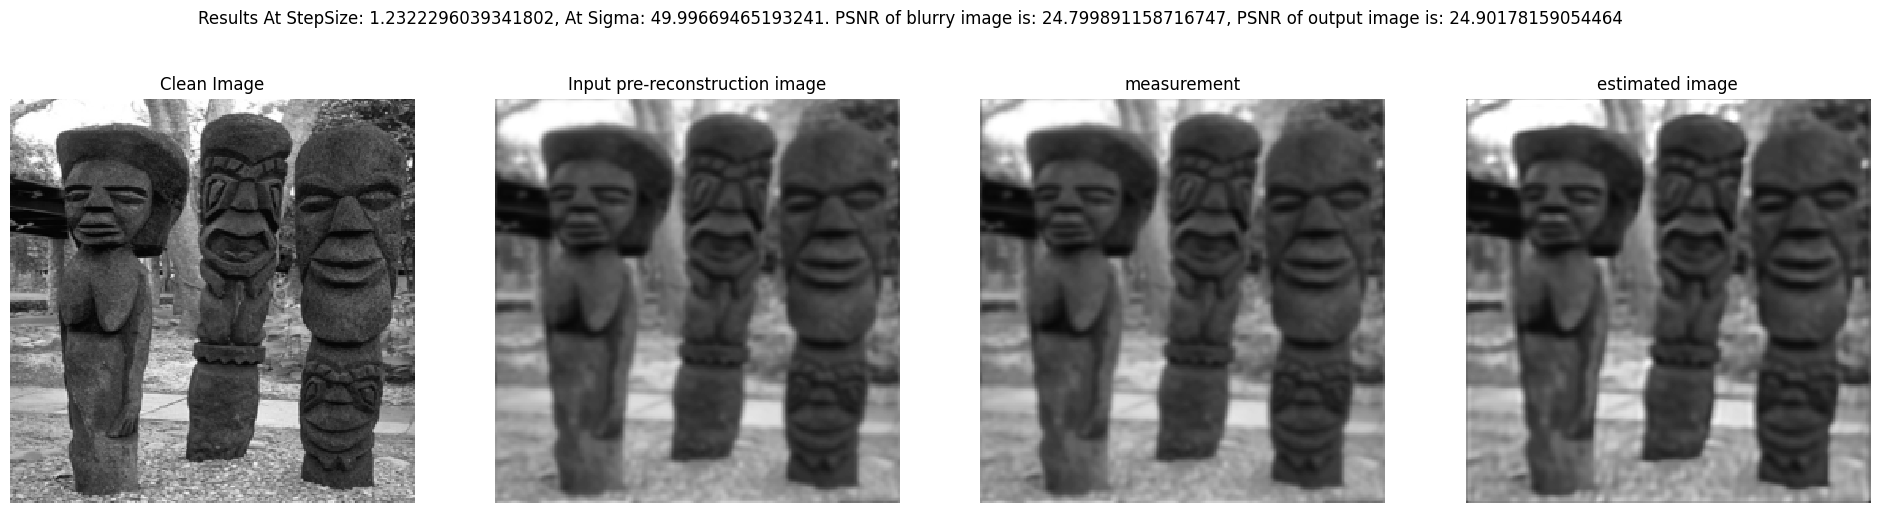

In [29]:
blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.numpy()
recon_np = recon.cpu().detach().numpy() if recon.is_cuda else recon.numpy()
mseTermRecon = mse(clean_img_np, recon_np)
mseTermBlurred = mse(clean_img_np,blurry_img_np)

finalPsnrOutput = psnrCalc(mseTermRecon,1)
finalPsnrMeas = psnrCalc(mseTermBlurred,1)

fig, ax = plt.subplots(1,4, figsize=(24,6))

fig.suptitle(f'Results At StepSize: {bestStepsize}, At Sigma: {sigma}. PSNR of blurry image is: {finalPsnrMeas}, PSNR of output image is: {finalPsnrOutput}')

ax[0].imshow(clean_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[0].set_title("Clean Image", fontsize=12)
ax[0].axis('off')
ax[1].imshow(x0[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[1].set_title("Input pre-reconstruction image", fontsize=12)
ax[1].axis('off')
ax[2].imshow(blurry_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[2].set_title("measurement", fontsize=12)
ax[2].axis('off')
ax[3].imshow(recon[0,0].cpu().detach().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[3].set_title("estimated image", fontsize=12)
ax[3].axis('off')